Загружаем датасет, удаляем пропуски, преобразуем текстовые данные

In [114]:
import pandas as pd
df = pd.read_csv('athletes.csv')
df.head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
id             11538 non-null int64
name           11538 non-null object
nationality    11538 non-null object
sex            11538 non-null object
dob            11537 non-null object
height         11208 non-null float64
weight         10879 non-null float64
sport          11538 non-null object
gold           11538 non-null int64
silver         11538 non-null int64
bronze         11538 non-null int64
dtypes: float64(2), int64(4), object(5)
memory usage: 991.6+ KB


In [116]:
df = df.dropna()
df = df.drop('name',axis=1)
df['dob'] = pd.to_datetime(df['dob'],format='%m/%d/%y').astype('int64')

In [117]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['nationality'] = le.fit_transform(df['nationality'])
df['sport'] = le.fit_transform(df['sport'])
df['sex'] = le.fit_transform(df['sex'])
df.head()

,id,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,59,1,-6566400000000000,1.72,64.0,2,0,0,0
1,532037425,101,0,527817600000000000,1.68,56.0,8,0,0,0
2,435962603,33,1,706924800000000000,1.98,79.0,2,0,0,1
3,521041435,117,1,662774400000000000,1.83,80.0,21,0,0,0
4,33922579,138,1,659577600000000000,1.81,71.0,6,0,0,0


In [118]:
y = df['sex']
X = df.drop('sex',axis=1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[ 0.80745074, -0.57809363, -2.70920102, ..., -0.22923469,
        -0.24128751, -0.24497681],
       [ 0.10622808,  0.14780202, -0.46781521, ..., -0.22923469,
        -0.24128751, -0.24497681],
       [-0.22400938, -1.0274576 ,  0.28342048, ..., -0.22923469,
        -0.24128751,  3.93734742],
       ..., 
       [-1.41881833, -0.94104145,  0.14607445, ..., -0.22923469,
        -0.24128751, -0.24497681],
       [ 1.37125044,  1.7724256 , -0.13260392, ..., -0.22923469,
        -0.24128751, -0.24497681],
       [ 0.72276581,  1.08109642,  0.23196102, ..., -0.22923469,
        -0.24128751, -0.24497681]])

Делим данные на обучающую и тестовую выборки, обучаем модель

In [119]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [120]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state = 0)
lr.fit(X_train, y_train)
y_pred_proba = lr.predict_proba(X_test)[:, 1]

In [121]:
lr.score(X_train, y_train)

0.77653695602118356

In [122]:
lr.score(X_test,y_test)

0.78084714548802947

Строим roc-кривую с помощью sklearn

In [123]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, treshold = roc_curve(y_test, y_pred_proba)

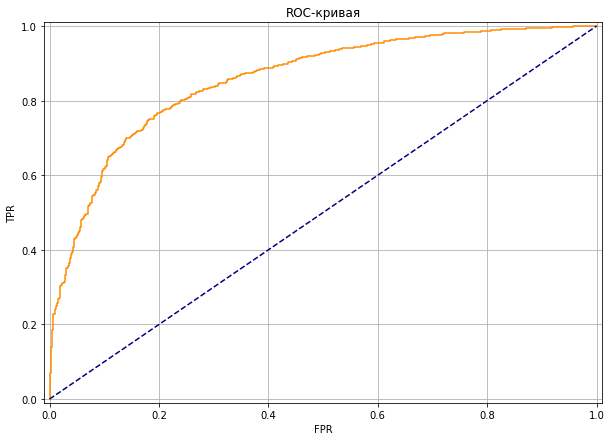

In [124]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.grid()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая')
plt.show()

ROC-AUC метрика

In [140]:
auc = roc_auc_score(y_test, y_pred_proba)
auc

0.85732239294917489

Считаем TPR, FPR и precision вручную, строим roc-кривую, накладываем кривую из sklearn

In [126]:
import numpy as np
fpr1 = []
tpr1 = []
precision = []
for t in range(100,0,-1):
    y_pred = np.where(y_pred_proba >= t/100, 1, 0)
    fp = np.sum((y_pred == 1) & (y_test == 0))
    tp = np.sum((y_pred == 1) & (y_test == 1))
    fn = np.sum((y_pred == 0) & (y_test == 1))
    tn = np.sum((y_pred == 0) & (y_test == 0))
    fpr1.append(fp / (fp + tn))
    tpr1.append(tp / (tp + fn))
    precision.append(tp / (tp + fp + 0.0000000001))

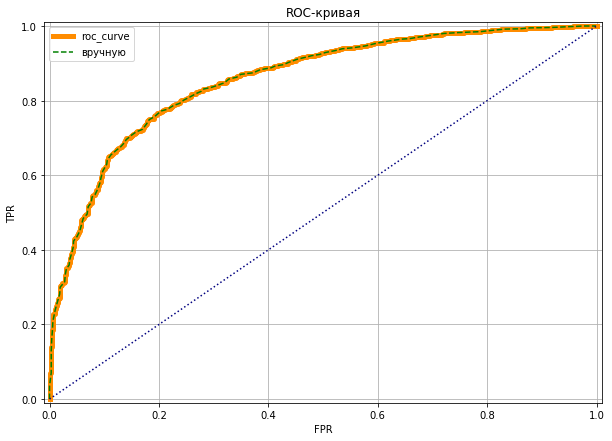

In [127]:
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', linewidth=5, label='roc_curve')
plt.plot(fpr1, tpr1, color='green', linestyle='--',label='вручную')
plt.plot([0, 1], [0, 1], color='navy', linestyle=':')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.grid()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая')
plt.legend()
plt.show()

Графики вполне ожидаемо совпали, поскольку построены на одних данных.

Строим график Precision-Recall

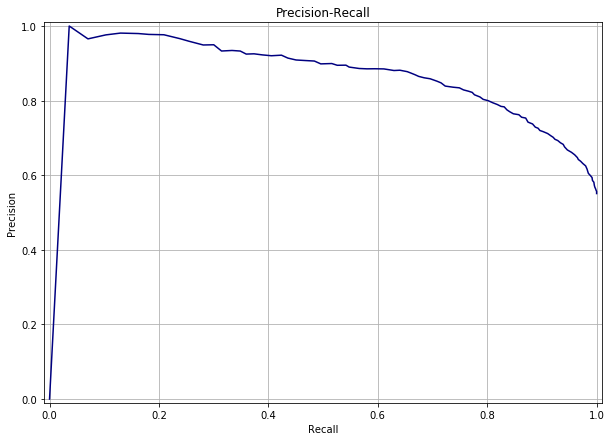

In [128]:
plt.figure(figsize=(10, 7))
plt.plot(tpr1, precision, color='navy')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.grid()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall')
plt.show()

Считаем ROC-AUC метрику вручную:

In [142]:
data = list(zip(y_test, y_pred_proba))
s1, s2 = 0, 0
for i in range(len(data)):
    for j in range(len(data)):
        if data[i][0] < data[j][0]:
            s1 += 1
            if data[i][1] < data[j][1]:
                s2 += 1
            elif data[i][1] == data[j][1]:
                s2 += 0.5
print(s2/s1)                

0.8573223929491749


Метрика совпала до последнего знака

**Выводы**

а) Чем большая площадь находится под графиками ROC-кривой и Precision-Recall, тем выше качество модели. Площадь под графиком 
ROC-кривой составила почти 0,86, что является хорошим показателем.

б) ROC-кривая может проходить ниже диагонали, если модель делает противоположные меткам предсказания.